In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib

from scipy.stats import qmc

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(precision=3)

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from botorch.utils.multi_objective.pareto import is_non_dominated

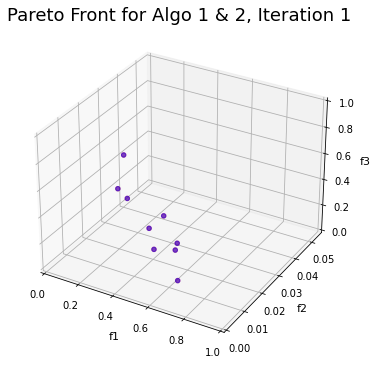

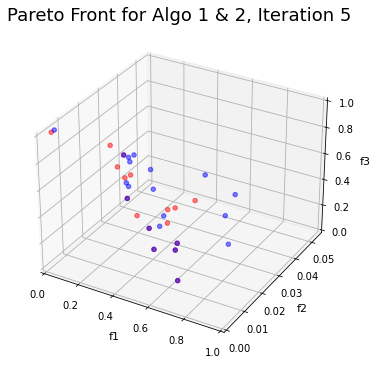

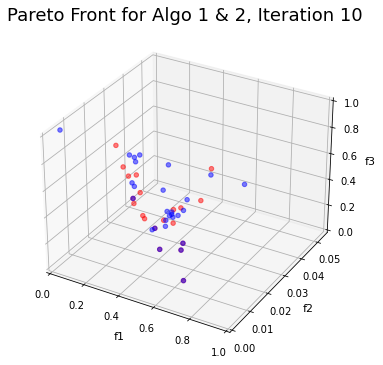

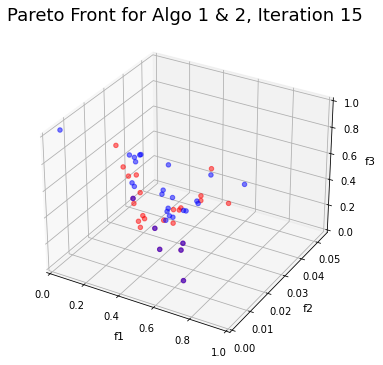

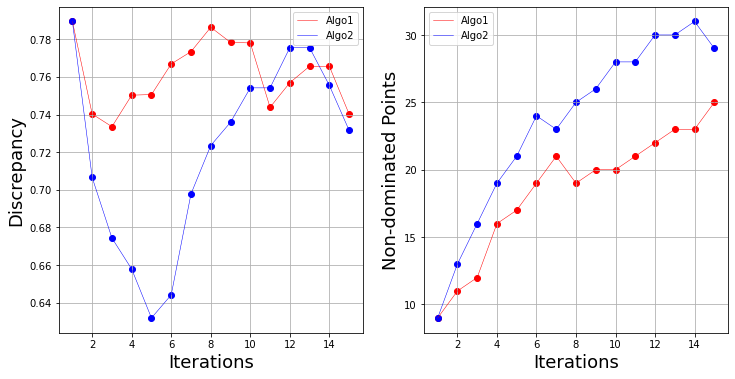

In [17]:
BATCH_SIZE = 4
n_var = 5
n_obj = 3

df1 = pd.read_csv('Results_Algo1_Run15.csv')
df2 = pd.read_csv('Results_Algo2_Run15.csv')


dis_list1, dis_list2 = [], []
pfsize_list1, pfsize_list2 = [], []

for current_iter in range(1,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df1.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    pareto_mask = is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]
    pareto_y_np1 = pareto_y.cpu().numpy()
    
    discrepancy = qmc.discrepancy(pareto_y_np1, method='MD')
    dis_list1.append(discrepancy)
    pfsize_list1.append(pareto_y_np1.shape[0])
    
    initial_x_torch = torch.tensor(df2.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]
    pareto_mask = is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]
    pareto_y_np2 = pareto_y.cpu().numpy()
    
    discrepancy = qmc.discrepancy(pareto_y_np2, method='MD')
    dis_list2.append(discrepancy)
    pfsize_list2.append(pareto_y_np2.shape[0])
    
    if current_iter == 1 or current_iter == 5 or current_iter == 10 or current_iter == 15:
        # plot the recorded r2 over all iterations 

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(projection='3d')

        ax.scatter3D(pareto_y_np1[:,0], pareto_y_np1[:,1], pareto_y_np1[:,2],
                            c='r', s=20, alpha=0.5)
        
        ax.scatter3D(pareto_y_np2[:,0], pareto_y_np2[:,1], pareto_y_np2[:,2],
                            c='b', s=20, alpha=0.5)

        ax.set_xlabel('f1', fontsize=11)
        ax.set_ylabel('f2', fontsize=11)
        ax.set_zlabel('f3', fontsize=11)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.055)
        ax.set_zlim(0, 1)
        
        ax.set_title(f"Pareto Front for Algo 1 & 2, Iteration {current_iter}", fontsize=18)

fig, ax = plt.subplots(ncols = 2, figsize = (12,6))

ax[0].plot(np.arange(1,15+1), dis_list1, linewidth=0.5, c='r', label='Algo1')
ax[0].scatter(np.arange(1,15+1), dis_list1, c='r')

ax[0].plot(np.arange(1,15+1), dis_list2, linewidth=0.5, c='b', label='Algo2')
ax[0].scatter(np.arange(1,15+1), dis_list2, c='b')

ax[0].set_xlabel('Iterations', fontsize=18)
ax[0].set_ylabel('Discrepancy', fontsize=18)
ax[0].legend()
ax[0].grid()


ax[1].plot(np.arange(1,15+1), pfsize_list1, linewidth=0.5, c='r', label='Algo1')
ax[1].scatter(np.arange(1,15+1), pfsize_list1, c='r')

ax[1].plot(np.arange(1,15+1), pfsize_list2, linewidth=0.5, c='b', label='Algo2')
ax[1].scatter(np.arange(1,15+1), pfsize_list2, c='b')

ax[1].set_xlabel('Iterations', fontsize=18)
ax[1].set_ylabel('Non-dominated Points', fontsize=18)
ax[1].legend()
ax[1].grid()


Text(0, 0.5, 'Discrepancy')

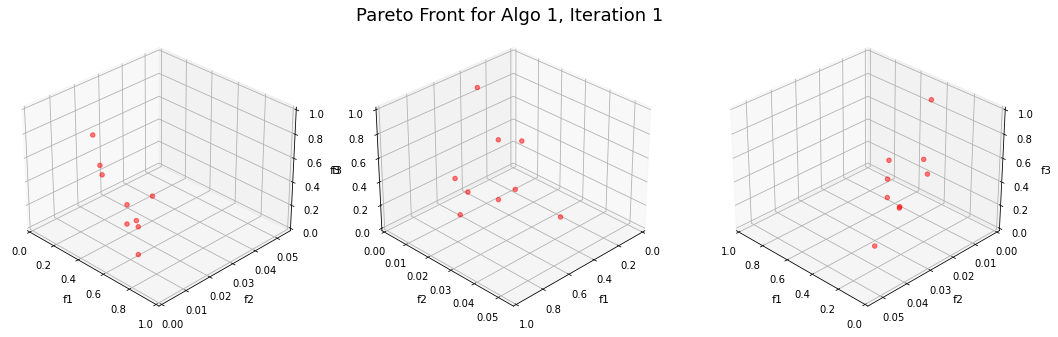

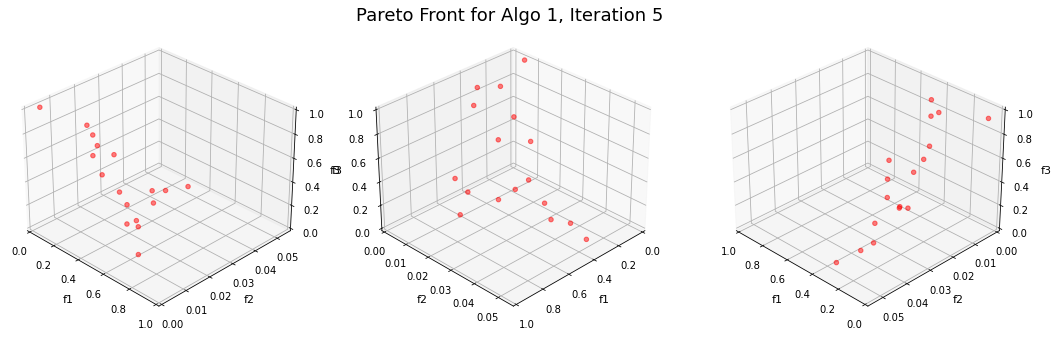

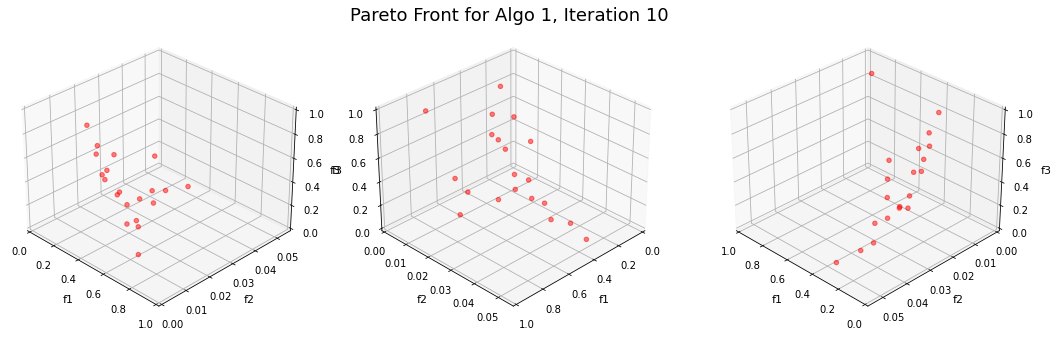

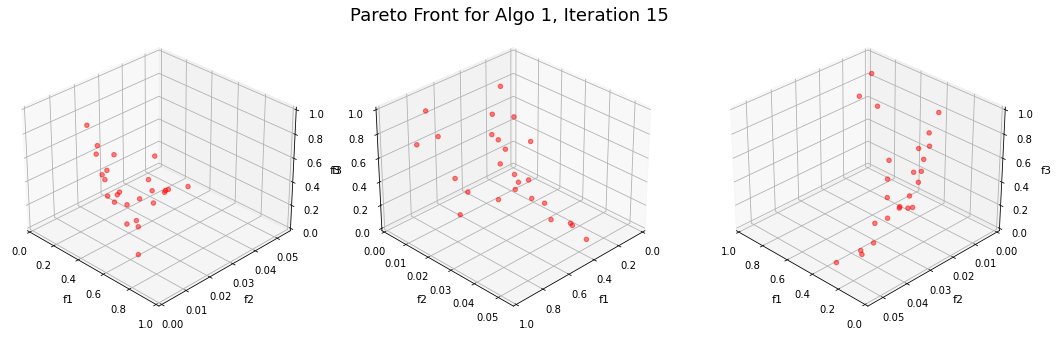

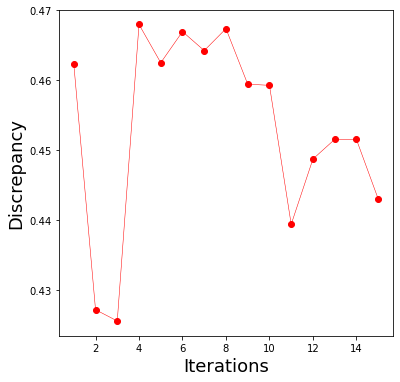

In [4]:
BATCH_SIZE = 4
n_var = 5
n_obj = 3

df = pd.read_csv('Results_Algo1_Run15.csv')

dis_list = []

for current_iter in range(1,15+1):

    ####################
    # initial training data
    initial_x_torch = torch.tensor(df.iloc[0:12+((current_iter-1)*BATCH_SIZE), 1:].values, **tkwargs)
    train_obj = initial_x_torch[:,n_var:n_var+n_obj]

    pareto_mask = is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]

    pareto_y_np = pareto_y.cpu().numpy()
    discrepancy = qmc.discrepancy(pareto_y_np)
    dis_list.append(discrepancy) # positive since we want lowest value 
    
    
    if current_iter == 1 or current_iter == 5 or current_iter == 10 or current_iter == 15:
        # plot the recorded r2 over all iterations
        views = [(1, (0, -45, 0)),
                 (2, (0, 45, 0)),
                 (3, (0, 135, 0)),]
        layout = [[1, 2, 3]]  

        fig, ax = plt.subplot_mosaic(layout, subplot_kw={'projection': '3d'},
                                      figsize=(18, 6))

        for plane, angles in views:

            ax[plane].scatter3D(pareto_y_np[:,0], pareto_y_np[:,1], pareto_y_np[:,2],
                                c='r', s=20, alpha=0.5)

            ax[plane].set_xlabel('f1', fontsize=11)
            ax[plane].set_ylabel('f2', fontsize=11)
            ax[plane].set_zlabel('f3', fontsize=11)

            ax[plane].set_xlim(0, 1)
            ax[plane].set_ylim(0, 0.055)
            ax[plane].set_zlim(0, 1)

            ax[plane].view_init(azim=angles[1])

        ax[2].set_title(f"Pareto Front for Algo 1, Iteration {current_iter}", fontsize=18)

# plot the recorded r2 over all iterations
fig, ax = plt.subplots(ncols = 1, figsize = (6,6))

ax.plot(np.arange(1,15+1), dis_list, linewidth=0.5, c='r')
    
ax.scatter(np.arange(1,15+1), dis_list, c='r')

ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Discrepancy', fontsize=18)

#fig.suptitle(f'Model Accuracy for Constraints', fontsize=25)    
#fig.tight_layout()        
